In [19]:
from pathlib import Path
import dotenv
from google import genai
dotenv.load_dotenv()

gem_client = genai.Client()


In [18]:

import base64
from io import BytesIO
from PIL import Image

path = "/home/ubuntu/documents/induction-labs/repos/synth/test_data/pull_main.png"
img = Image.open(path)

def pil_to_b64(image: Image.Image, fmt: str = "PNG") -> str:
    buf = BytesIO()
    image.save(buf, format=fmt)
    return base64.b64encode(buf.getvalue()).decode("ascii")

image_b64 = pil_to_b64(img, fmt="PNG")
data_uri = f"data:image/png;base64,{image_b64}"


In [37]:
from litellm import completion 
import os


for _ in range(2):
    response = completion(
        model="gpt-4o",
        messages=[
            # System Message
            {
                "role": "system",
                "content": [
                    {
                        "type": "text",
                        "text": "Here is the full text of a complex legal agreement"
                        * 400,
                    }
                ],
            },
            # marked for caching with the cache_control parameter, so that this checkpoint can read from the previous cache.
            {
                "role": "user",
                "content": [
                    # {
                    #     "type": "text",
                    #     "text": "What are the key terms and conditions in this agreement?",
                    # },
                     {
                        "type": "image_url",
                        "image_url": {
                            "url": data_uri,
                            "detail": "high",
                        },
                    },
                ],
                
            },
            {
                "role": "assistant",
                "content": "Certainly! the key terms and conditions are the following: the contract is 1 year long for $10/mo",
            },
            # The final turn is marked with cache-control, for continuing in followups.
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": "What are the key terms and conditions in this agreement?",
                    "cache_control": {"type": "ephemeral"},
                    }
                ],
            },
        ],
        temperature=0.2,
        max_tokens=10,
    )

print("response=", response)
print("response.usage=", response.usage)

assert "prompt_tokens_details" in response.usage
assert response.usage.prompt_tokens_details.cached_tokens > 0

response= ModelResponse(id='chatcmpl-C3bQAfhY830CqJslojY3twf4tXqz8', created=1754974866, model='gpt-4o-2024-08-06', object='chat.completion', system_fingerprint='fp_ff25b2783a', choices=[Choices(finish_reason='length', index=0, message=Message(content='The image is a stylized illustration of a character', role='assistant', tool_calls=None, function_call=None, provider_specific_fields={'refusal': None}, annotations=[]), provider_specific_fields={})], usage=Usage(completion_tokens=10, prompt_tokens=5157, total_tokens=5167, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None)), service_tier='default')
response.usage= Usage(completion_tokens=10, prompt_tokens=5157, total_tokens=5167, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_predict

AssertionError: 

In [ ]:
# pip install --upgrade openai pillow
from openai import OpenAI

client = OpenAI()  # uses OPENAI_API_KEY from env

# --- load + b64 encode image ---

# --- shared conversation (identical prefix to benefit from prompt caching) ---
conversation = [
    {"role": "system",
     "content": [{"type": "input_text",
                  "text": "Here is the full text of a complex legal agreement"* 400}]},
    {"role": "user",
     "content": [
        #  {"type": "input_image", "image_url": data_uri},
         {"type": "input_text",
          "text": "What are the key terms and conditions in this agreement?" },
     ]},
    {"role": "assistant",
     "content": [{"type": "output_text",
                  "text": "Certainly! the key terms and conditions are the following: the contract is 1 year long for $10/mo"}]},
    {"role": "user",
     "content": [{"type": "input_text",
                  "text": "What are the key terms and conditions in this agreement?"}]},
]
resp = None
for i in range(2):
    resp = client.responses.create(
        model="gpt-4o",
        input=conversation,
        extra_body={
            "prompt_cache_key": "test_prompt_cache_key",  # use a fixed key to hit the cache
        },
        max_output_tokens=1000,  # limit output length
    )

    print(f"\n--- call {i+1} ---")
    print("text:", resp)
    print("usage:", resp.usage)

    # prompt caching visibility

assert resp.usage is not None
assert resp.usage.input_tokens_details is not None
assert (resp.usage.input_tokens_details.cached_tokens or 0) > 0, \
    "cached_tokens == 0 (need a >=1024-token shared prefix to hit the cache)"



--- call 1 ---
text: To accurately identify the key terms and conditions of an agreement, I would typically highlight sections related to parties involved, duration, payment terms, obligations, termination clauses, confidentiality, and dispute resolution. However, since I can't see the actual document, you would need to look for these elements within the text.

If you have specific sections or clauses you want reviewed, feel free to share, and I can help explain or clarify them.
usage: ResponseUsage(input_tokens=4063, input_tokens_details=InputTokensDetails(cached_tokens=3840), output_tokens=86, output_tokens_details=OutputTokensDetails(reasoning_tokens=0), total_tokens=4149)

--- call 2 ---
text: To help you effectively, I'd need some details about the agreement's specific sections. Generally, key terms and conditions in a legal agreement might include:

1. **Parties Involved**: Who is entering the agreement.
2. **Definitions**: Key terms defined within the agreement.
3. **Duration**

AssertionError: cached_tokens == 0 (need a >=1024-token shared prefix to hit the cache)

In [12]:
# actions_path = Path("../../../test_data/action_capture_jeffrey_2025-06-27_121528_AX8OE_action_capture_000000.jsonl")
# actions = load_actions(actions_path)
# actions
import importlib
import synth.recordings.gemini_process
importlib.reload(synth.recordings.gemini_process)
from synth.recordings.synth_captions_generated_samples import get_actions

from synth.recordings.gemini_process import load_metadata
# actions_path = "gs://induction-labs-data-ext/action_capture/Jarry/2025-07-07_002920_0SPCN"
actions_path = "gs://induction-labs-data-ext/action_capture/jonathan/2025-07-17_093647_KZ3CG"
# actions_path = "gs://induction-labs-data-ext/action_capture/joyceliu/2025-07-04_110139_B6VYF"
# actions_path = "gs://induction-labs-data-ext/action_capture/aryan_91532/2025-07-08_160952_VX5RU"
# actions_path="gs://induction-labs-data-ext/action_capture/Kunal/2025-07-19_150406_A27L7"
video_metadata = load_metadata(actions_path)
print(video_metadata)

raw_actions = get_actions(actions_path)


[08/14/25 23:16:34] WARNING  Platform not specified in metadata                              ]8;id=544513;file:///home/ubuntu/documents/induction-labs/repos/synth/src/synth/recordings/gemini_process.py\gemini_process.py]8;;\:]8;id=367442;file:///home/ubuntu/documents/induction-labs/repos/synth/src/synth/recordings/gemini_process.py#1268\1268]8;;\
                             metadata_path='induction-labs-data-ext/action_capture/jonathan/                       
                             2025-07-17_093647_KZ3CG/metadata.json'. Setting to unknown.                           

timestamp=1752770210.045 username='jonathan' screen_info=ScreenInfo(video_width=3024, video_height=1964, logical_pixel_ratio=2.0, logical_pixel_width=1512, logical_pixel_height=982) video_segment_buffer_length=30 time_base=Fraction(1, 1000000) platform=<Platform.unknown: 'unknown'>


In [13]:
import pandas as pd



# raw_actions = pd.DataFrame(raw_actions)
# raw_actions = raw_actions[raw_actions["timestamp"] >=1751949210.534025]
filtered_raw_actions = raw_actions
filtered_raw_actions = [k for k in raw_actions if k["timestamp"] >= 1752770715.175921]
filtered_raw_actions

[{'action': {'action': 'key_button', 'key': 'esc', 'is_down': False},
  'timestamp': 1752770715.229186},
 {'action': {'action': 'key_button', 'key': 'a', 'is_down': True},
  'timestamp': 1752770715.3682702},
 {'action': {'action': 'key_button', 'key': 'a', 'is_down': False},
  'timestamp': 1752770715.4486113},
 {'action': {'action': 'key_button', 'key': ';', 'is_down': True},
  'timestamp': 1752770715.490609},
 {'action': {'action': 'key_button', 'key': ';', 'is_down': False},
  'timestamp': 1752770715.585143},
 {'action': {'action': 'key_button', 'key': 'esc', 'is_down': True},
  'timestamp': 1752770715.6454113},
 {'action': {'action': 'key_button', 'key': 'esc', 'is_down': False},
  'timestamp': 1752770715.7215083},
 {'action': {'action': 'key_button', 'key': 'shift', 'is_down': True},
  'timestamp': 1752770715.8527262},
 {'action': {'action': 'key_button', 'key': '>', 'is_down': True},
  'timestamp': 1752770715.95212},
 {'action': {'action': 'key_button', 'key': '>', 'is_down': Fals

In [18]:
import importlib
import synth.recordings.parse_actions
import synth.recordings.gemini_process
import synth.recordings.transform_coordinates

importlib.reload(synth.recordings.parse_actions)
importlib.reload(synth.recordings.gemini_process)
importlib.reload(synth.recordings.transform_coordinates)

from synth.recordings.parse_actions import parse_actions, Action, ScrollAction, Point, ClickAction
from synth.recordings.gemini_process import combine_scroll_actions,  combine_actions, get_target_resolution
from synth.recordings.transform_coordinates import (
    RecordingMetadata,
    transform_action_coords_list,
)
parsed_actions = parse_actions(filtered_raw_actions)
target_resolution = get_target_resolution(video_metadata)
print(f"Target resolution: {target_resolution}")
transformed_actions = transform_action_coords_list(
    parsed_actions,
    target_resolution,
    video_metadata
)

combined_actions = combine_actions(transformed_actions)
print(len(combined_actions))
combined_actions 


Target resolution: 1764x1148
2637


[Action(action=TypeAction(action_type='type', content='a;'), timestamp=1752770715.3682702, end_timestamp=1752770715.585143),
 Action(action=HotkeyAction(action_type='hotkey', modifiers=set(), key='esc'), timestamp=1752770715.6454113, end_timestamp=1752770715.7215083),
 Action(action=TypeAction(action_type='type', content='>>>>>>>>>>>>>>>>>>>>'), timestamp=1752770715.95212, end_timestamp=1752770718.6967092),
 Action(action=HotkeyAction(action_type='hotkey', modifiers=set(), key='esc'), timestamp=1752770718.8849082, end_timestamp=1752770718.9873102),
 Action(action=HotkeyAction(action_type='hotkey', modifiers={'cmd'}, key='s'), timestamp=1752770719.085719, end_timestamp=1752770719.1653862),
 Action(action=HotkeyAction(action_type='hotkey', modifiers={'cmd'}, key='tab'), timestamp=1752770719.362057, end_timestamp=1752770719.543981),
 Action(action=ScrollAction(action_type='scroll', point=Point(x=834, y=706), direction='down', displacement=(-11, -417)), timestamp=1752770720.154217, end_tim

<Axes: title={'center': 'Action Timestamps'}, xlabel='Index', ylabel='Timestamp'>

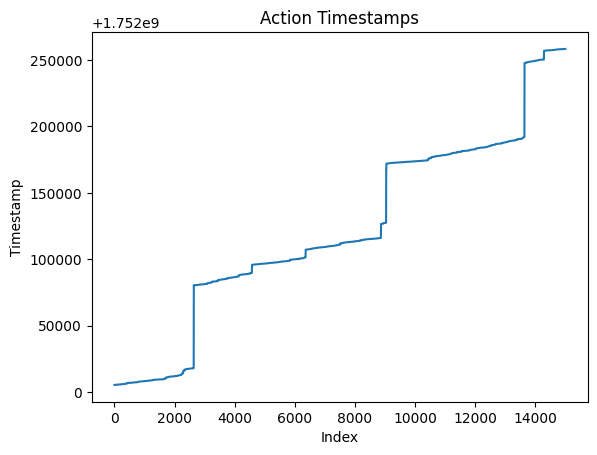

In [ ]:
# combined_actions = combined_actions[:15000]
action_timestamps = [a.timestamp for a in combined_actions]

# Plot the action timestamps
import matplotlib.pyplot as plt
series = pd.Series(action_timestamps)
series.plot(title="Action Timestamps", xlabel="Index", ylabel="Timestamp")

count    92.000000
mean     11.065217
std      10.023932
min       1.000000
25%       4.000000
50%       8.000000
75%      15.250000
max      54.000000
dtype: float64
92


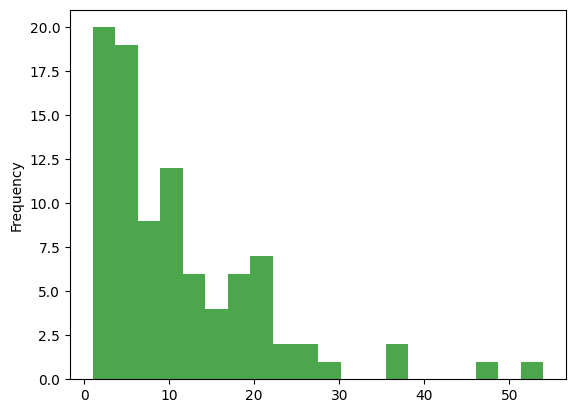

In [22]:
from synth.recordings.gemini_process import segment_actions_by_time_gaps, reverse_chunk_actions_to_length
import pandas as pd
segmented_actions = segment_actions_by_time_gaps(combined_actions, 5.0)
# segmented_actions = [k for segment in segmented_actions for k in reverse_chunk_actions_to_length(segment)]
segmented_lengths = [len(segment) for segment in segmented_actions]
segmented_lengths = pd.Series(segmented_lengths)
print(segmented_lengths.describe())
print(len(segmented_actions))
import matplotlib.pyplot as plt
segmented_lengths.plot(kind='hist', bins=20, alpha=0.7, color='green')
plt.show()

In [5]:

import pandas as pd
actions_df = pd.DataFrame([{"action": a, "start_timestamp": a.timestamp, 
                            "end_timestamp": a.end_timestamp, 
                            "action_type": a.action.action_type
                            } for a in combined_actions])
actions_df.head()


actions_df['action_type'].value_counts()
# actions_df.head().iloc[0]['start_timestamp']
# actions_df['action'].iloc[0]

action_type
hotkey          200
click           172
scroll          111
type             76
left_double      24
drag              3
right_single      1
Name: count, dtype: int64

In [25]:
import synth.recordings.gemini_process
import synth.recordings.parse_actions
import importlib
importlib.reload(synth.recordings.parse_actions)
importlib.reload(synth.recordings.gemini_process)
from synth.recordings.gemini_process import get_timesteps_range, get_target_resolution
action_set = segmented_actions[0][0:10]
start_time, timesteps = get_timesteps_range(action_set)
print(start_time, timesteps)
action_set

1751863800.092917 [1751863800.359581, 1751863800.4738307, 1751863800.6029696, 1751863800.7279668, 1751863801.3079028, 1751863804.4105842, 1751863805.512651, 1751863807.8791227, 1751863809.9293017, 1751863810.7258463]


[Action(action=TypeAction(action_type='type', content='<Backspace>'), timestamp=1751863800.292917, end_timestamp=1751863800.3329122),
 Action(action=TypeAction(action_type='type', content='<Backspace>'), timestamp=1751863800.399584, end_timestamp=1751863800.4469132),
 Action(action=TypeAction(action_type='type', content='<Backspace>'), timestamp=1751863800.5142071, end_timestamp=1751863800.573882),
 Action(action=TypeAction(action_type='type', content='<Backspace>'), timestamp=1751863800.646601, end_timestamp=1751863800.694901),
 Action(action=TypeAction(action_type='type', content='<Backspace>'), timestamp=1751863800.777565, end_timestamp=1751863800.8031192),
 Action(action=TypeAction(action_type='type', content='wall storage'), timestamp=1751863802.065078, end_timestamp=1751863804.011497),
 Action(action=ClickAction(action_type='click', modifiers=set(), point=Point(x=375, y=375)), timestamp=1751863805.009215, end_timestamp=1751863805.092499),
 Action(action=ScrollAction(action_type='

In [26]:
import importlib
import synth.recordings.gemini_process
importlib.reload(synth.recordings.gemini_process)
from synth.recordings.gemini_process import get_frames_at_timestamps, get_target_resolution

frames = get_frames_at_timestamps(actions_path, video_metadata, [start_time, *timesteps], target_resolution=get_target_resolution(video_metadata) )

In [40]:

from synapse.video_loader.video import download_video_with_ffmpeg_copy
from pathlib import Path
from synapse.video_loader.video import VideoMetadataFetcher
import av

video_output_path = Path("../../../test_data/test_video.mp4")
download_video_with_ffmpeg_copy(
    source_path="gs://induction-labs-data-ext/action_capture/aryan_91532/2025-07-08_160952_VX5RU/screen_capture_000414.mp4",
    dest_path=video_output_path.as_posix(),
    ffmpeg_path="/nix/store/q7j5awbg80d38p9my5b5zgn0xadgvbmb-ffmpeg-7.1.1-bin/bin/ffmpeg"
)
video_container = av.open(video_output_path.as_posix())
container_metadata = VideoMetadataFetcher.get_video_metadata(
                video_container.streams.video[0]
            )

# # video_path = Path("../../../test_data/action_capture_jeffrey_2025-06-27_121528_AX8OE_screen_capture_000084.mp4")
start_time = float(container_metadata.start_pts * container_metadata.time_base)
end_time = float(container_metadata.end_pts * container_metadata.time_base) 

time_bounds = (start_time, end_time)
print(time_bounds)
print((end_time - video_metadata.timestamp)/30)

(1752017816.371, 1752017846.856214)
415.01687380472816


In [31]:
# Filter df for actions within the video time bounds
start, end = time_bounds
filtered_actions_df = actions_df[(actions_df['start_timestamp'] >= start) & (actions_df['end_timestamp'] <= end)]
filtered_actions = filtered_actions_df["action"].tolist()
# first_timestamp = int(filtered_actions[0][2]) if len(filtered_actions) > 0 else 0
# for k in filtered_actions:
    # k[2] = k[2]- first_timestamp
filtered_actions

[Action(action=TypeAction(action_type='type', content='npm i -g @'), timestamp=1754858185.7871203, end_timestamp=1754858187.9271371),
 Action(action=HotkeyAction(action_type='hotkey', modifiers={'cmd'}, key='`'), timestamp=1754858188.175196, end_timestamp=1754858188.218485),
 Action(action=TypeAction(action_type='type', content='npm i -'), timestamp=1754858188.919529, end_timestamp=1754858189.501357),
 Action(action=HotkeyAction(action_type='hotkey', modifiers=set(), key='right'), timestamp=1754858189.7006621, end_timestamp=1754858189.7006621),
 Action(action=LeftDoubleAction(action_type='left_double', modifiers=set(), point=Point(x=425, y=784)), timestamp=1754858190.665126, end_timestamp=1754858190.8483143),
 Action(action=LeftDoubleAction(action_type='left_double', modifiers=set(), point=Point(x=425, y=784)), timestamp=1754858190.881437, end_timestamp=1754858190.94914),
 Action(action=ClickAction(action_type='click', modifiers=set(), point=Point(x=333, y=781)), timestamp=1754858191.5

Frame 0 metadata timestamp=1752009452.238092 original_timestamp=1752009452.218543 video_path='gs://induction-labs-data-ext/action_capture/aryan_91532/2025-07-08_160952_VX5RU/screen_capture_000135.mp4'


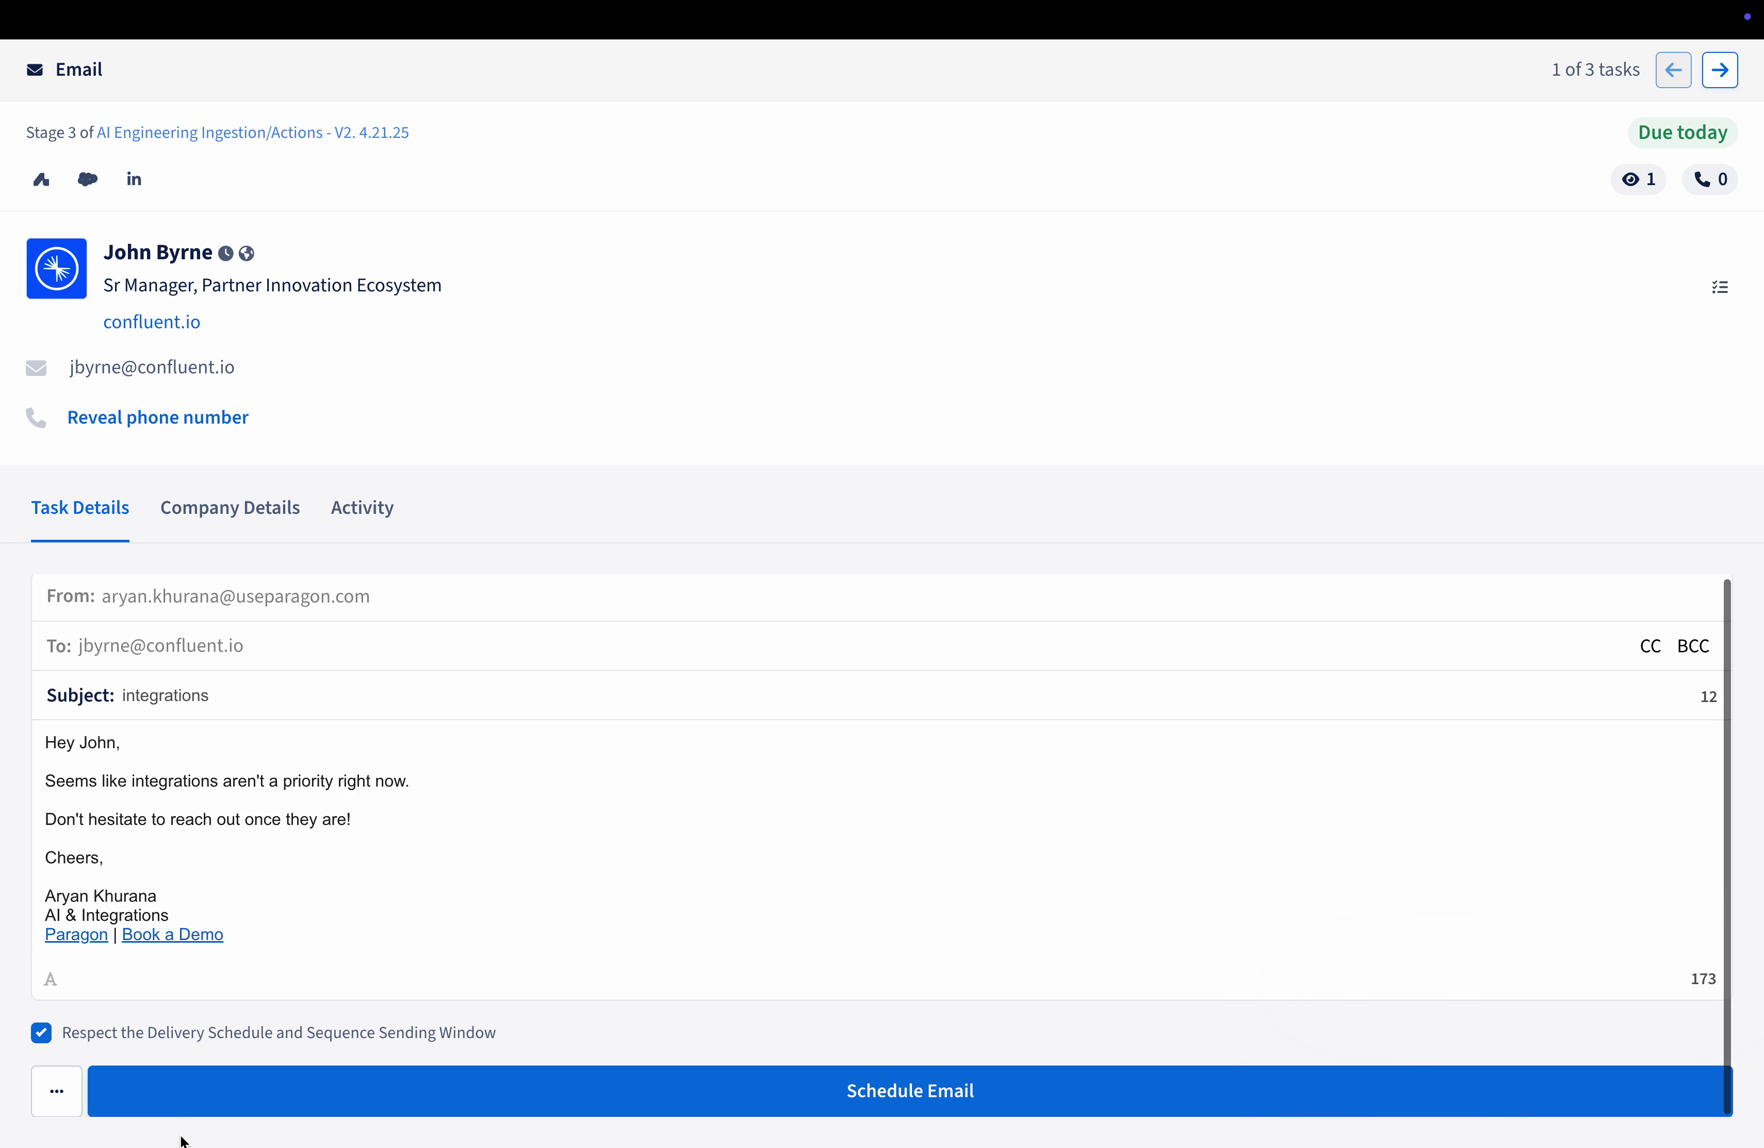

In [41]:
import importlib
import synth.recordings.synth_captions_generated_samples
importlib.reload(synth.recordings.synth_captions_generated_samples)
from synth.recordings.synth_captions_generated_samples import extract_frames_by_pts
import synth.recordings.gemini_process
import synth.recordings.parse_actions
importlib.reload(synth.recordings.parse_actions)
importlib.reload(synth.recordings.gemini_process)
from synth.recordings.gemini_process import get_timesteps_range

# action_range = (0,5)
# actions = filtered_actions[action_range[0]:action_range[1]]

# before_timestamp, action_end_timestamps = get_timesteps_range(actions)

# print(action_before)
# for action in actions:
#     print(action)

# frames = extract_frames_by_pts(video_output_path, [before_timestamp, *action_end_timestamps])
i=0
frame, metadata = frames[0]
print(f"Frame {i} metadata {metadata}")
frame

Frame 2 at timestamp=1752009452.848601 original_timestamp=1752009452.815215 video_path='gs://induction-labs-data-ext/action_capture/aryan_91532/2025-07-08_160952_VX5RU/screen_capture_000135.mp4'
Action: action=ClickAction(action_type='click', modifiers={'cmd'}, point=Point(x=159, y=812)) timestamp=1752009453.285088 end_timestamp=1752009453.335145
Drawing circle at (159, 812)


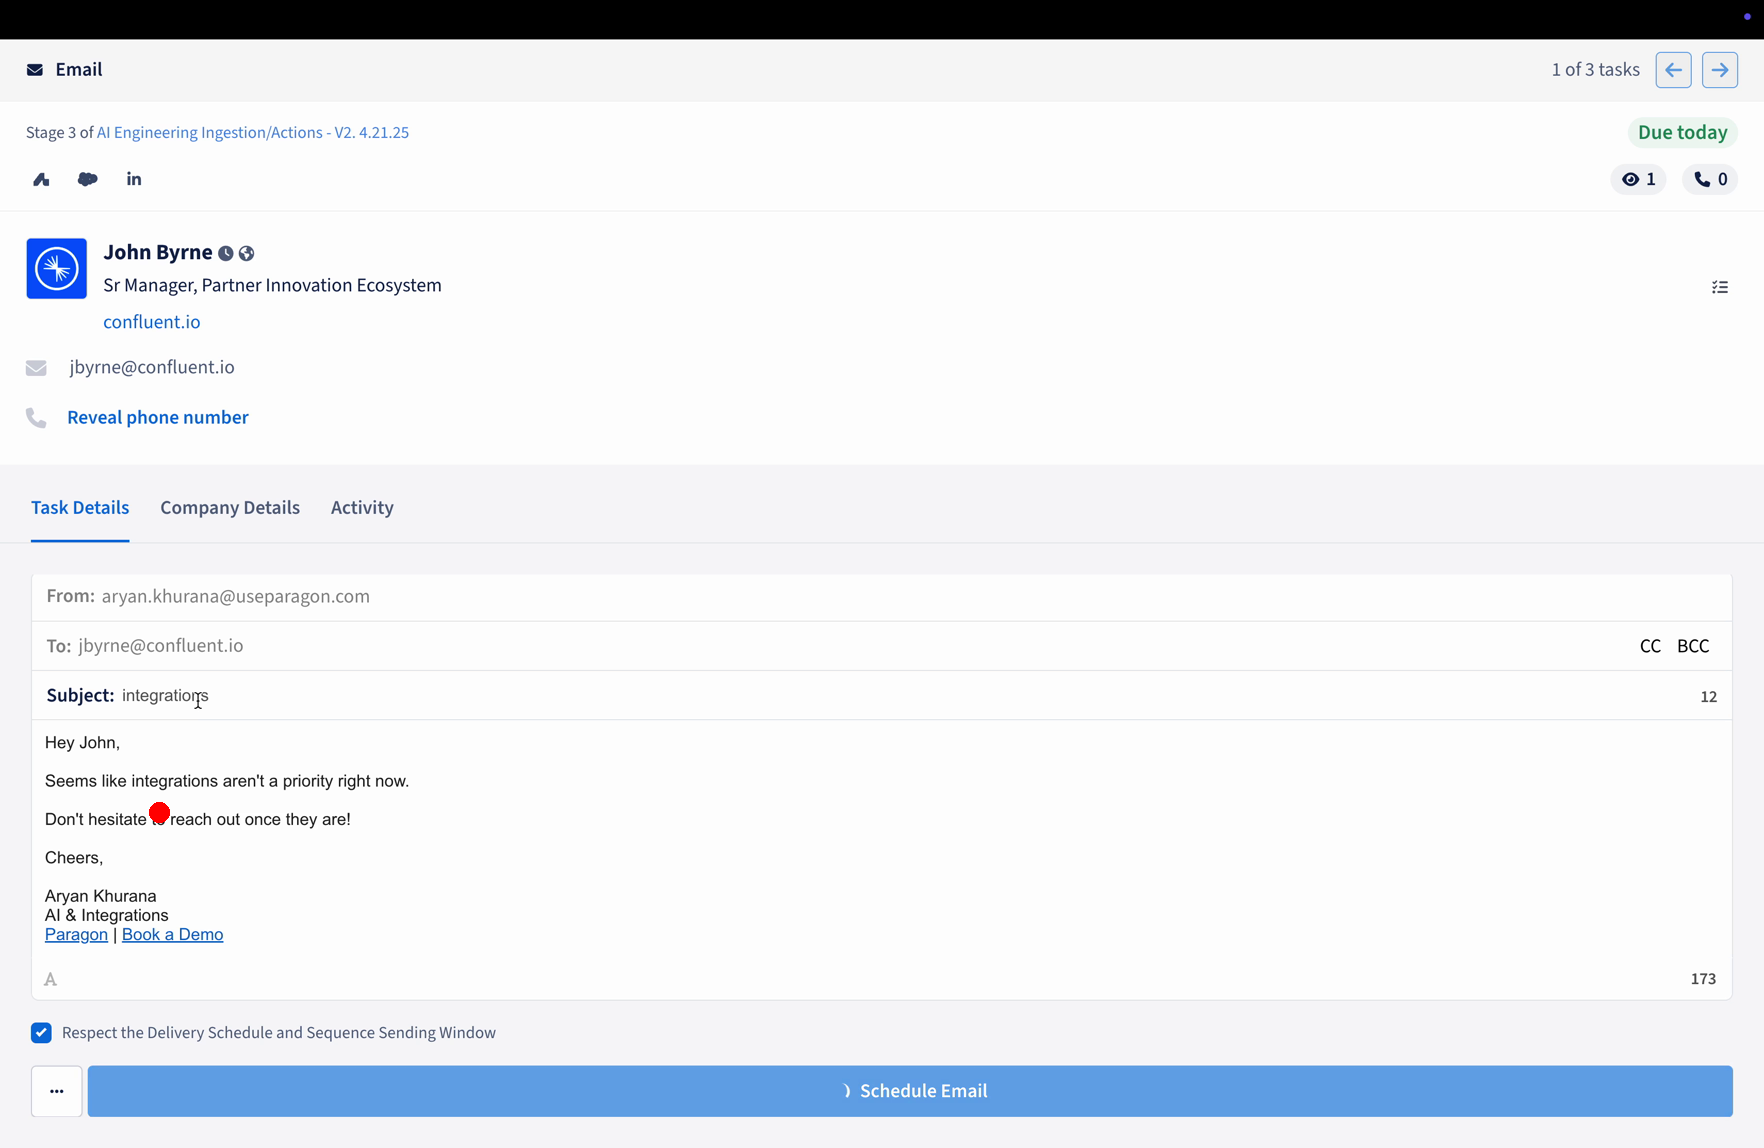

In [38]:
from PIL import Image, ImageDraw
# i = 6

# i = 0
action = action_set[i]
i = i + 1
frame, metadata = frames[i]
print(f"Frame {i} at {metadata}")
print(f"Action: {action}")
LOGICAL_RATIO = 2.0
if hasattr(action.action, 'point'):
  frame = frame.copy()
  # print(f"Click point: {action.action.point}")
  draw = ImageDraw.Draw(frame)
  # print frame dimensions

  coords = action.action.point
  x = coords.x
  y = coords.y
  print(f"Drawing circle at ({x}, {y})")
  # Draw a circle around the click point
  draw.ellipse((x - 10, y - 10, x + 10, y + 10), fill="red",)
# frame
# 1752008495.627283 1752008497.6273522
frame

[{'type': 'text',
  'text': 'The following are a series of screenshots and the actions a user took from a video recording of performing a task. The `i`th screenshot is taken right before the user performs the `i`th action, resulting in the `i+1`th screenshot.'},
 {'type': 'text', 'text': '\n\nScreenshot #1:'},
 {'type': 'image_url',
  'image_url': {'url': ''}},
 {'type': 'text',
  'text': "Action #1: click(start_box='(179,1108)'). (The point that was clicked (179, 1108) is highlighted in red.)"},
 {'type': 'text', 'text': '\n\nScreenshot #2:'},
 {'type': 'image_url',
  'image_url': {'url': ''}},
 {'type': 'text',
  'text': "Action #2: click(start_box='(159,812)', modifiers='cmd'). (The point that was clicked (159, 812) is highlighted in red.)"},
 {'type': 'text', 'text': '\n\nScreenshot #3:'},
 {'type': 'image_url',
  'image_url': {'url': ''}},
 {'type': 'text', 'text': "Action #3: hotkey(key='a', modifiers='cmd')."},
 {'type': 'text', 'text': '\n\nScreenshot #4:'},
 {'type': 'image_ur
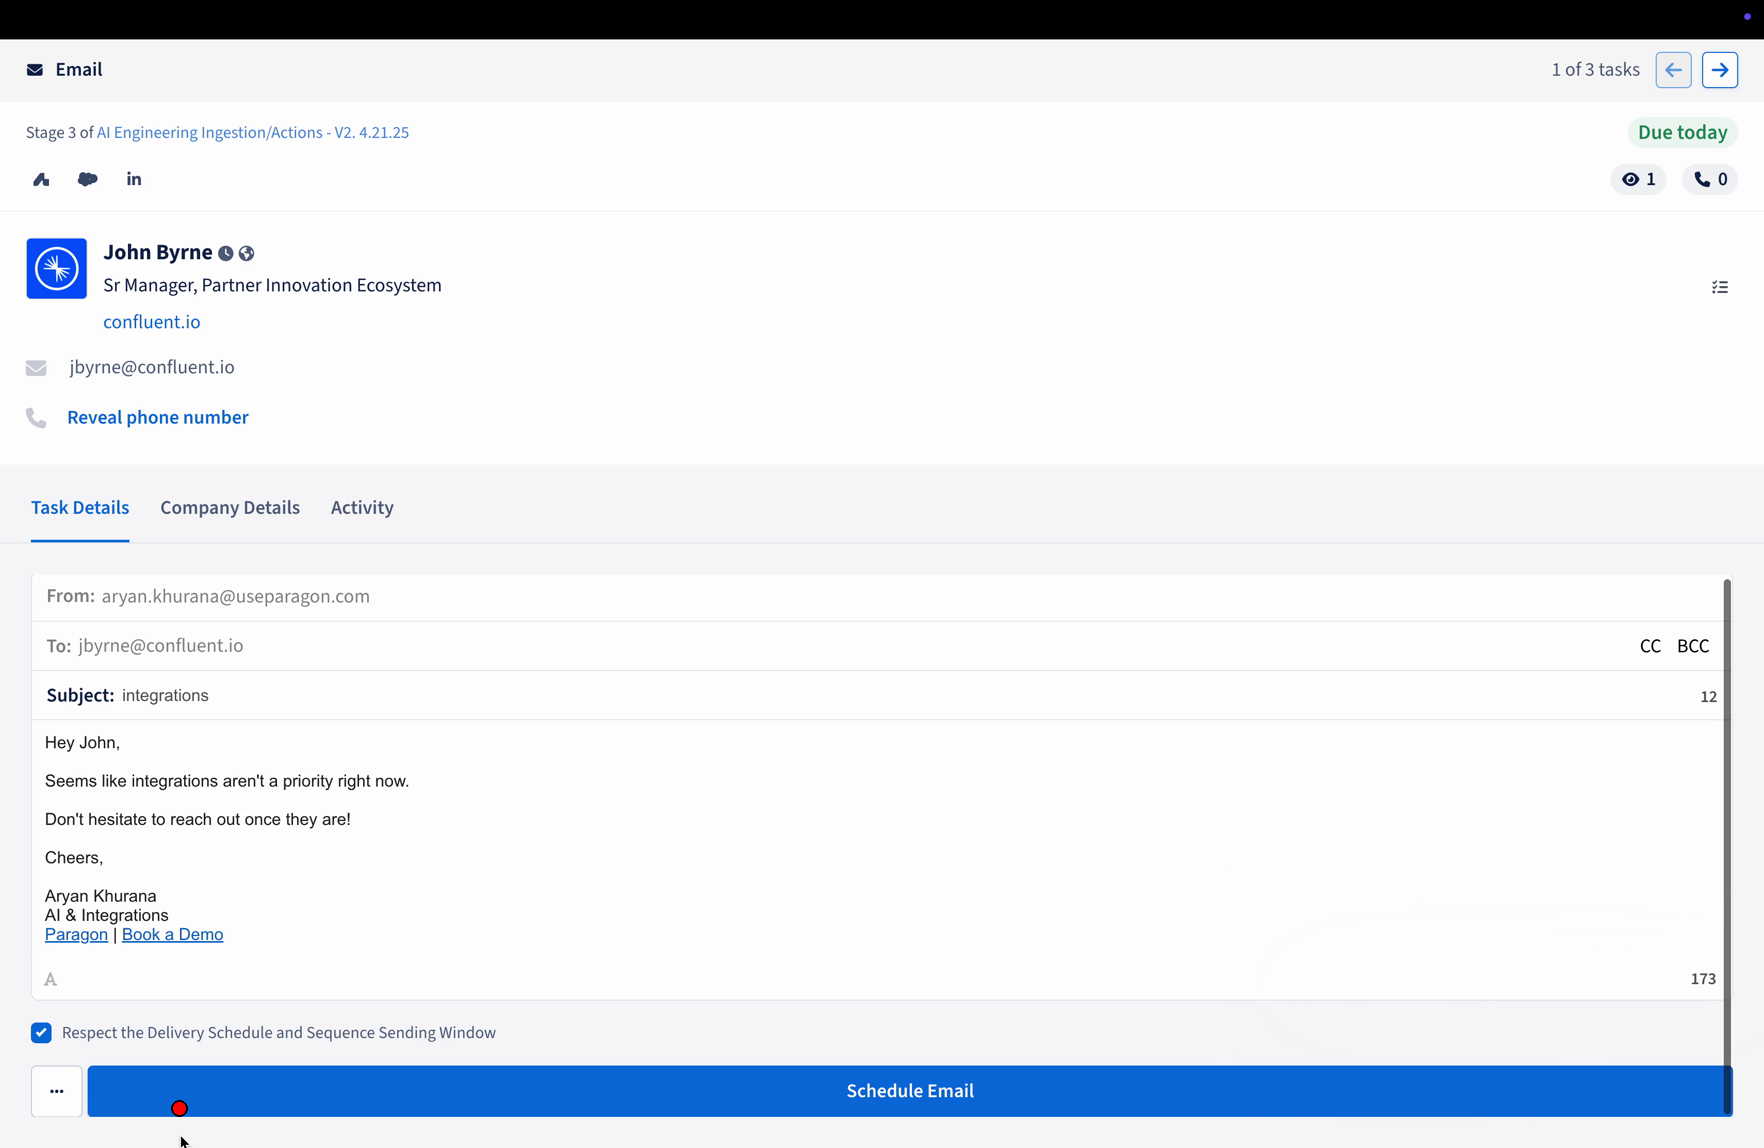
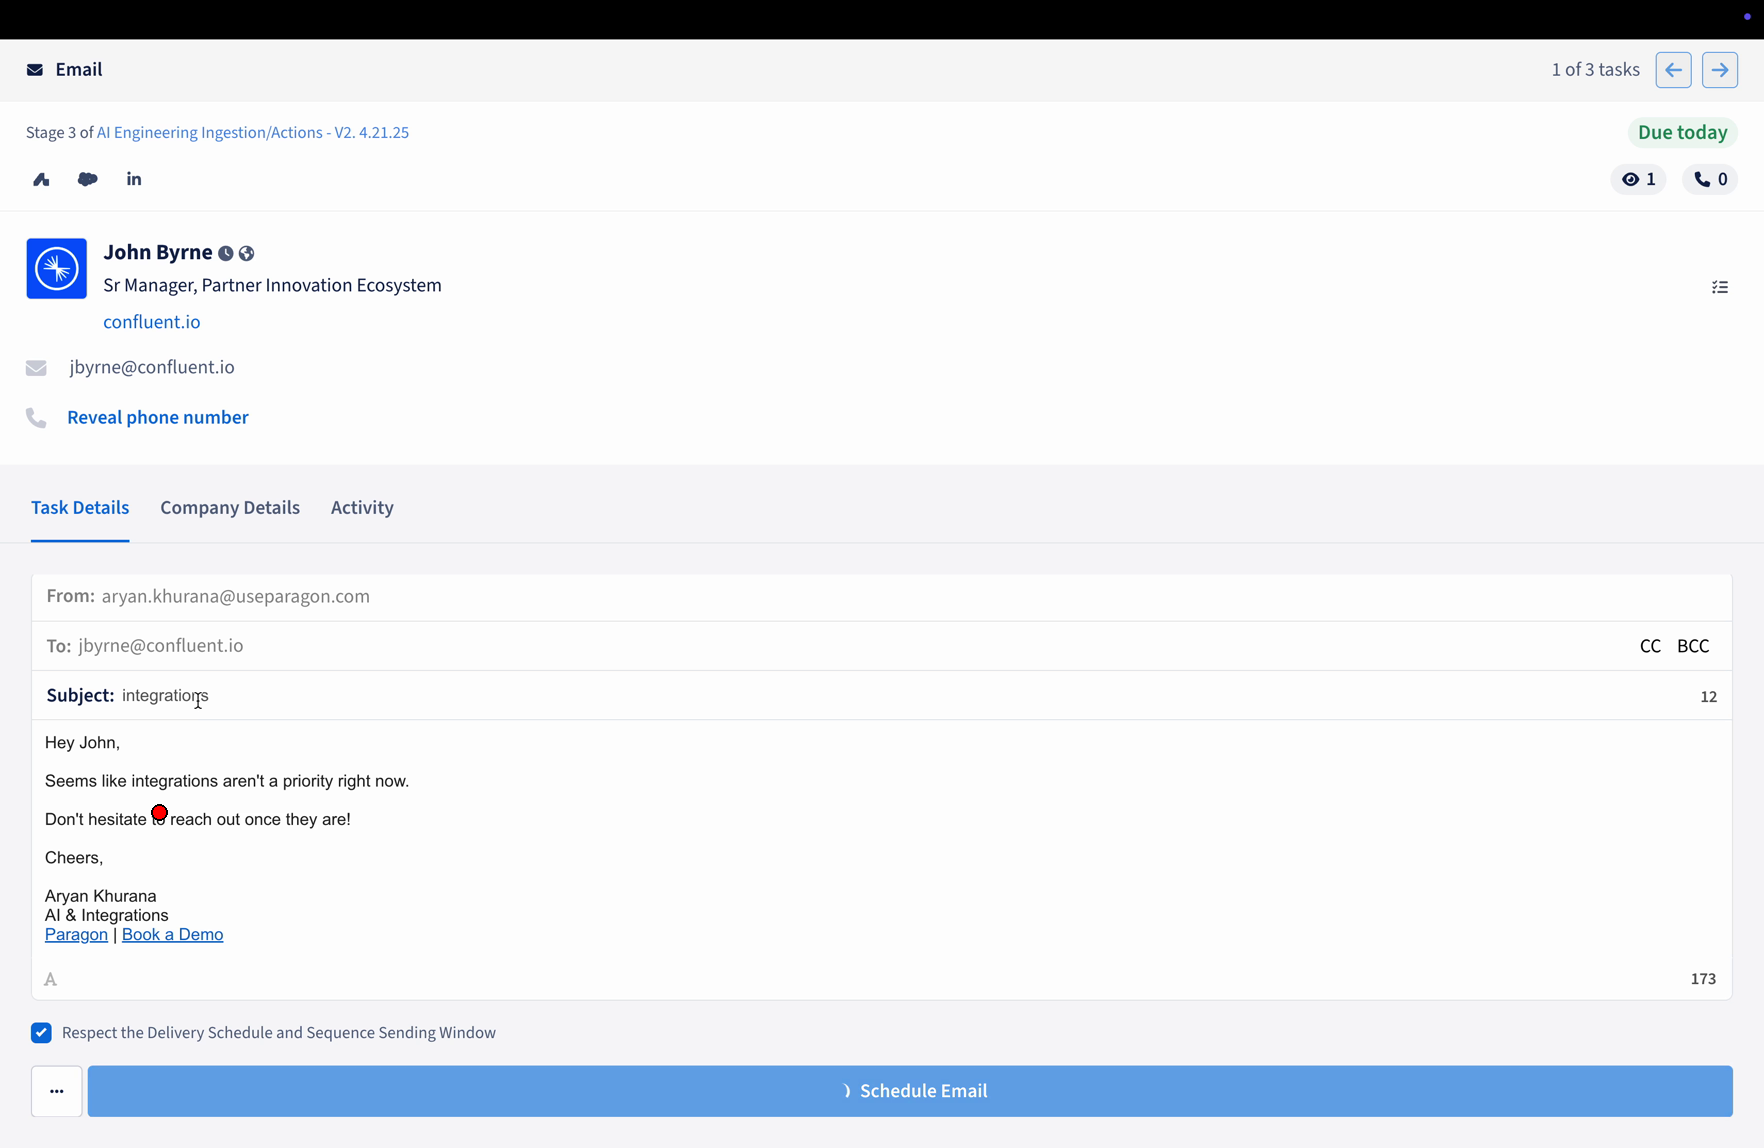
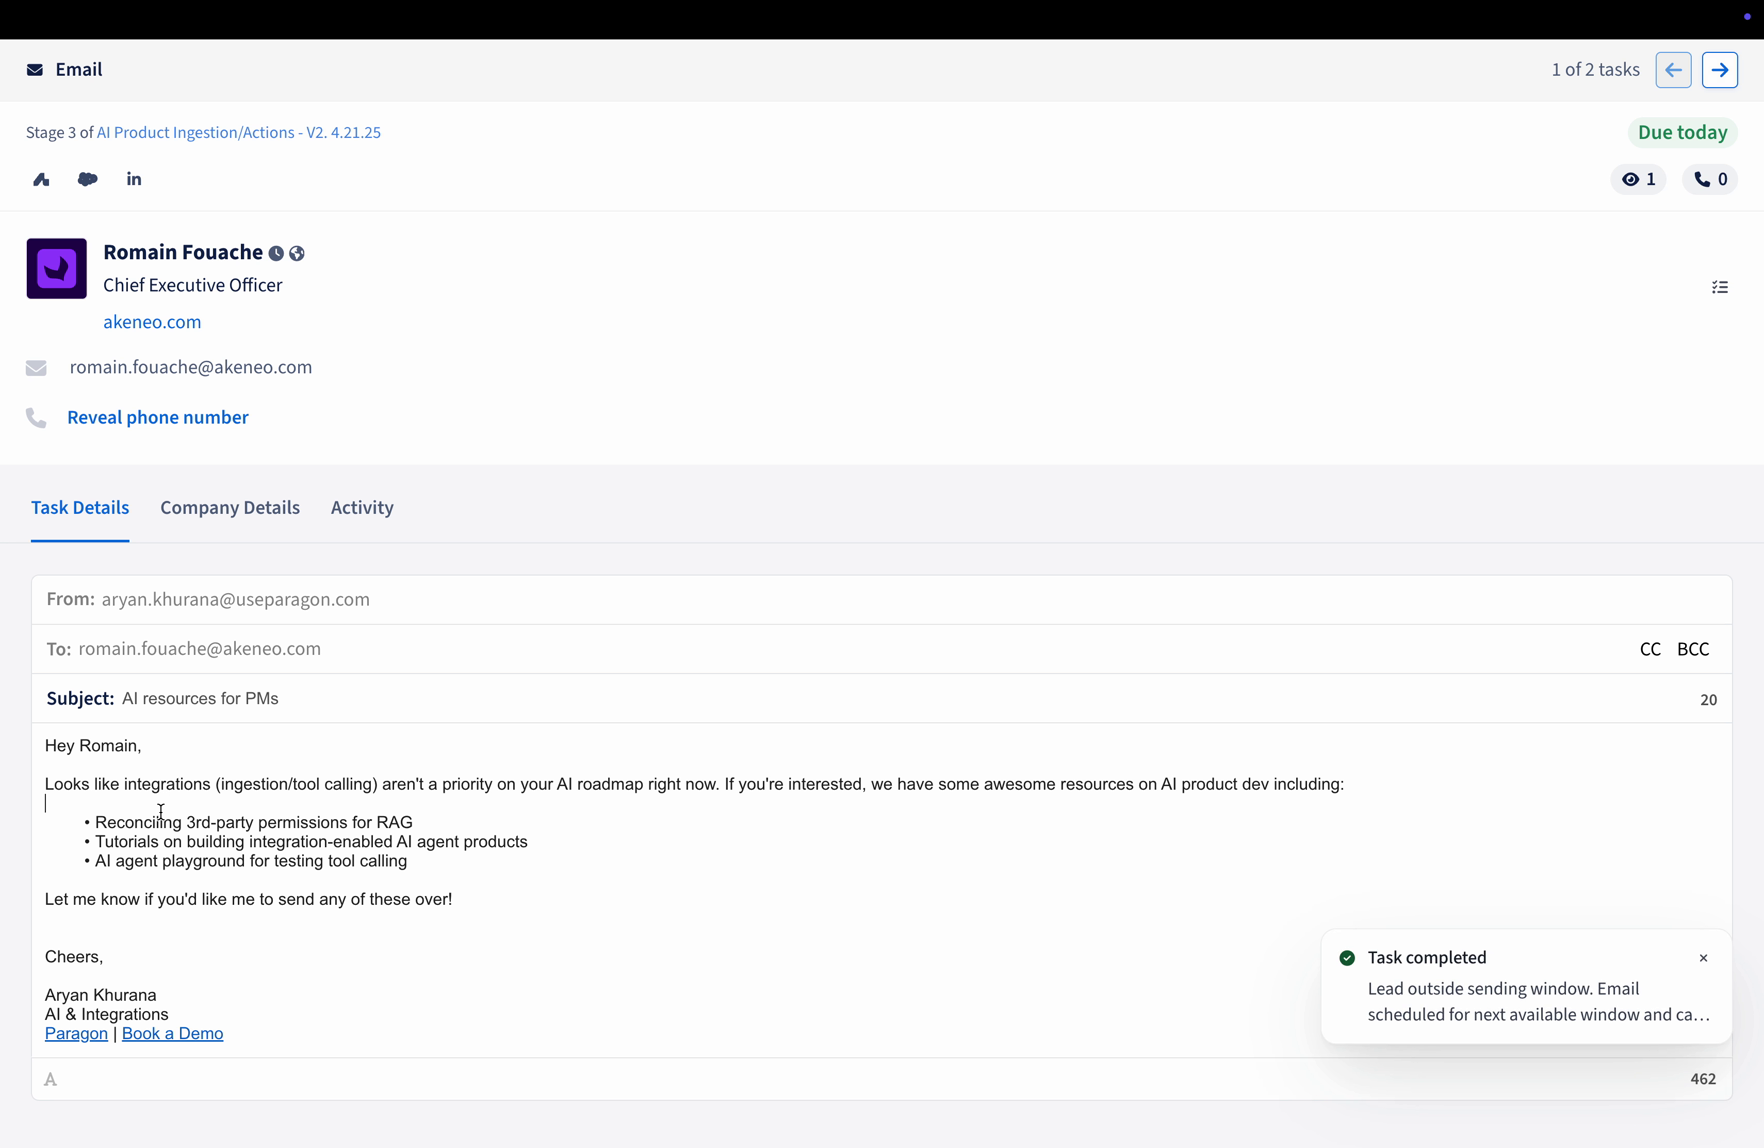
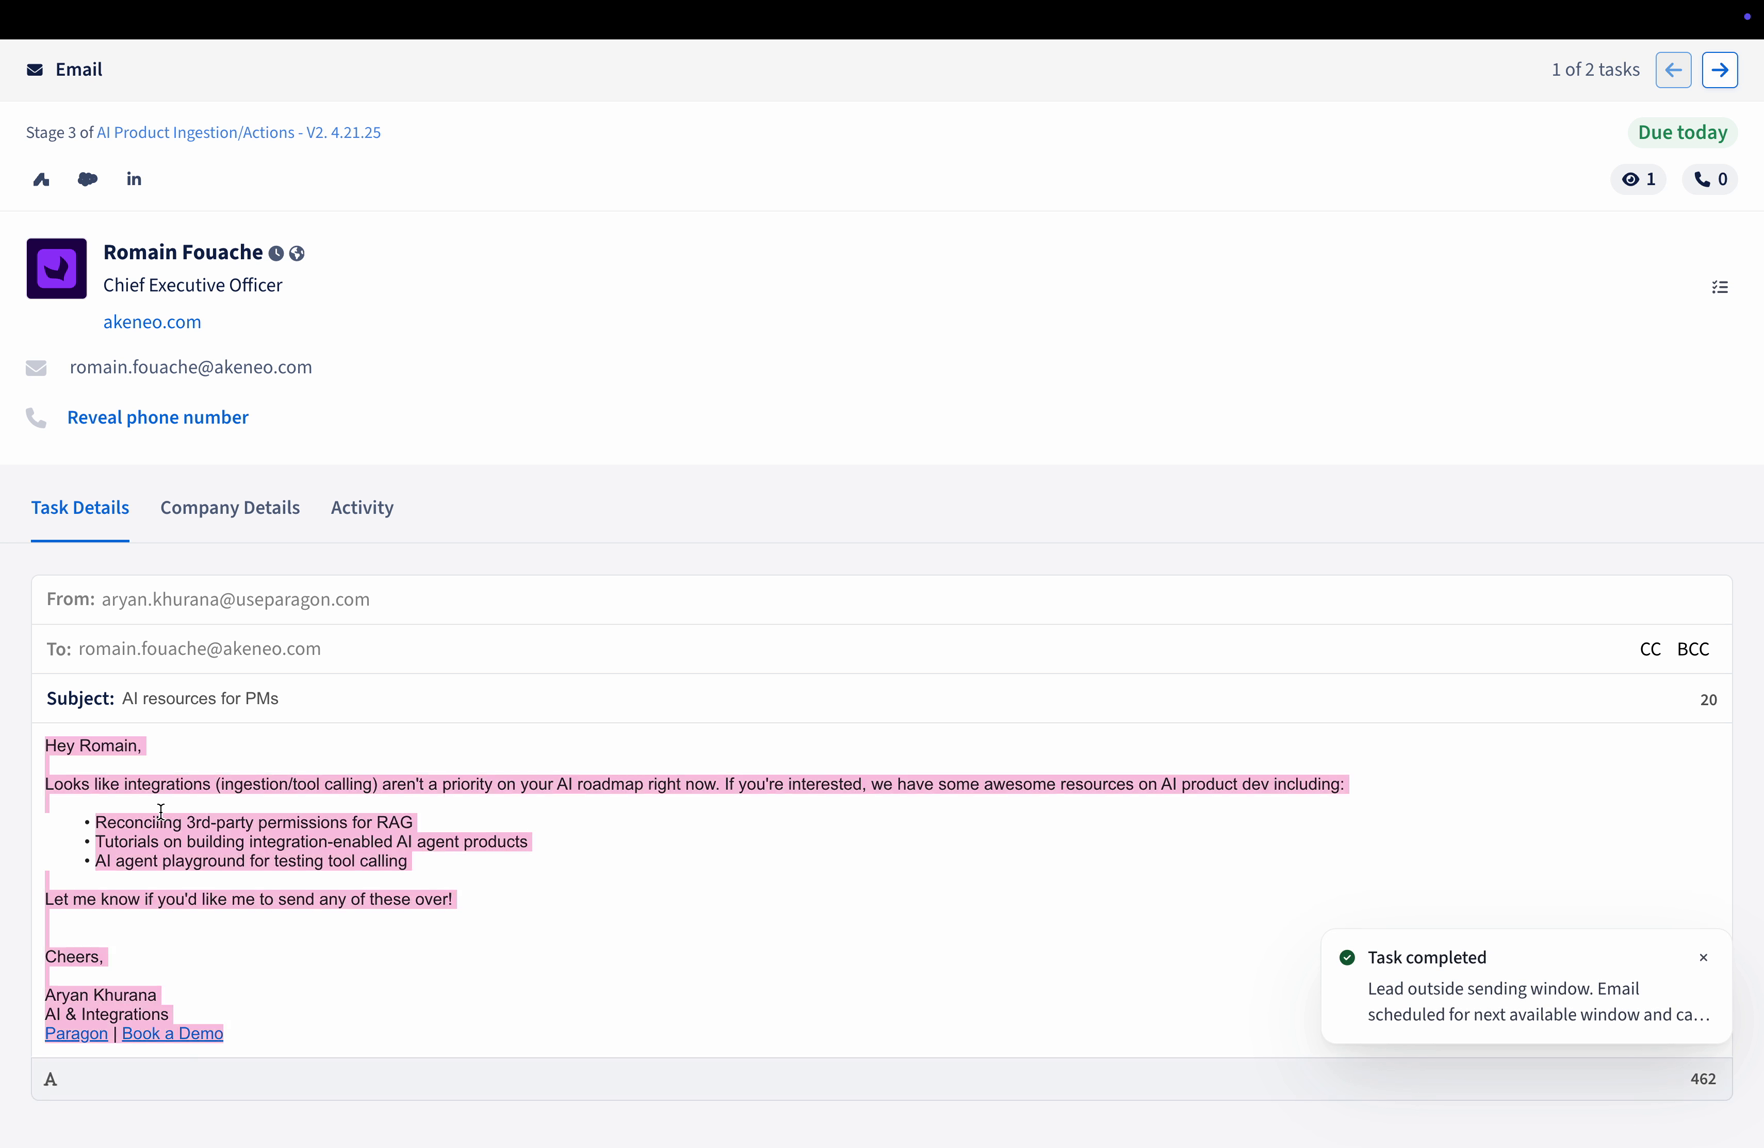
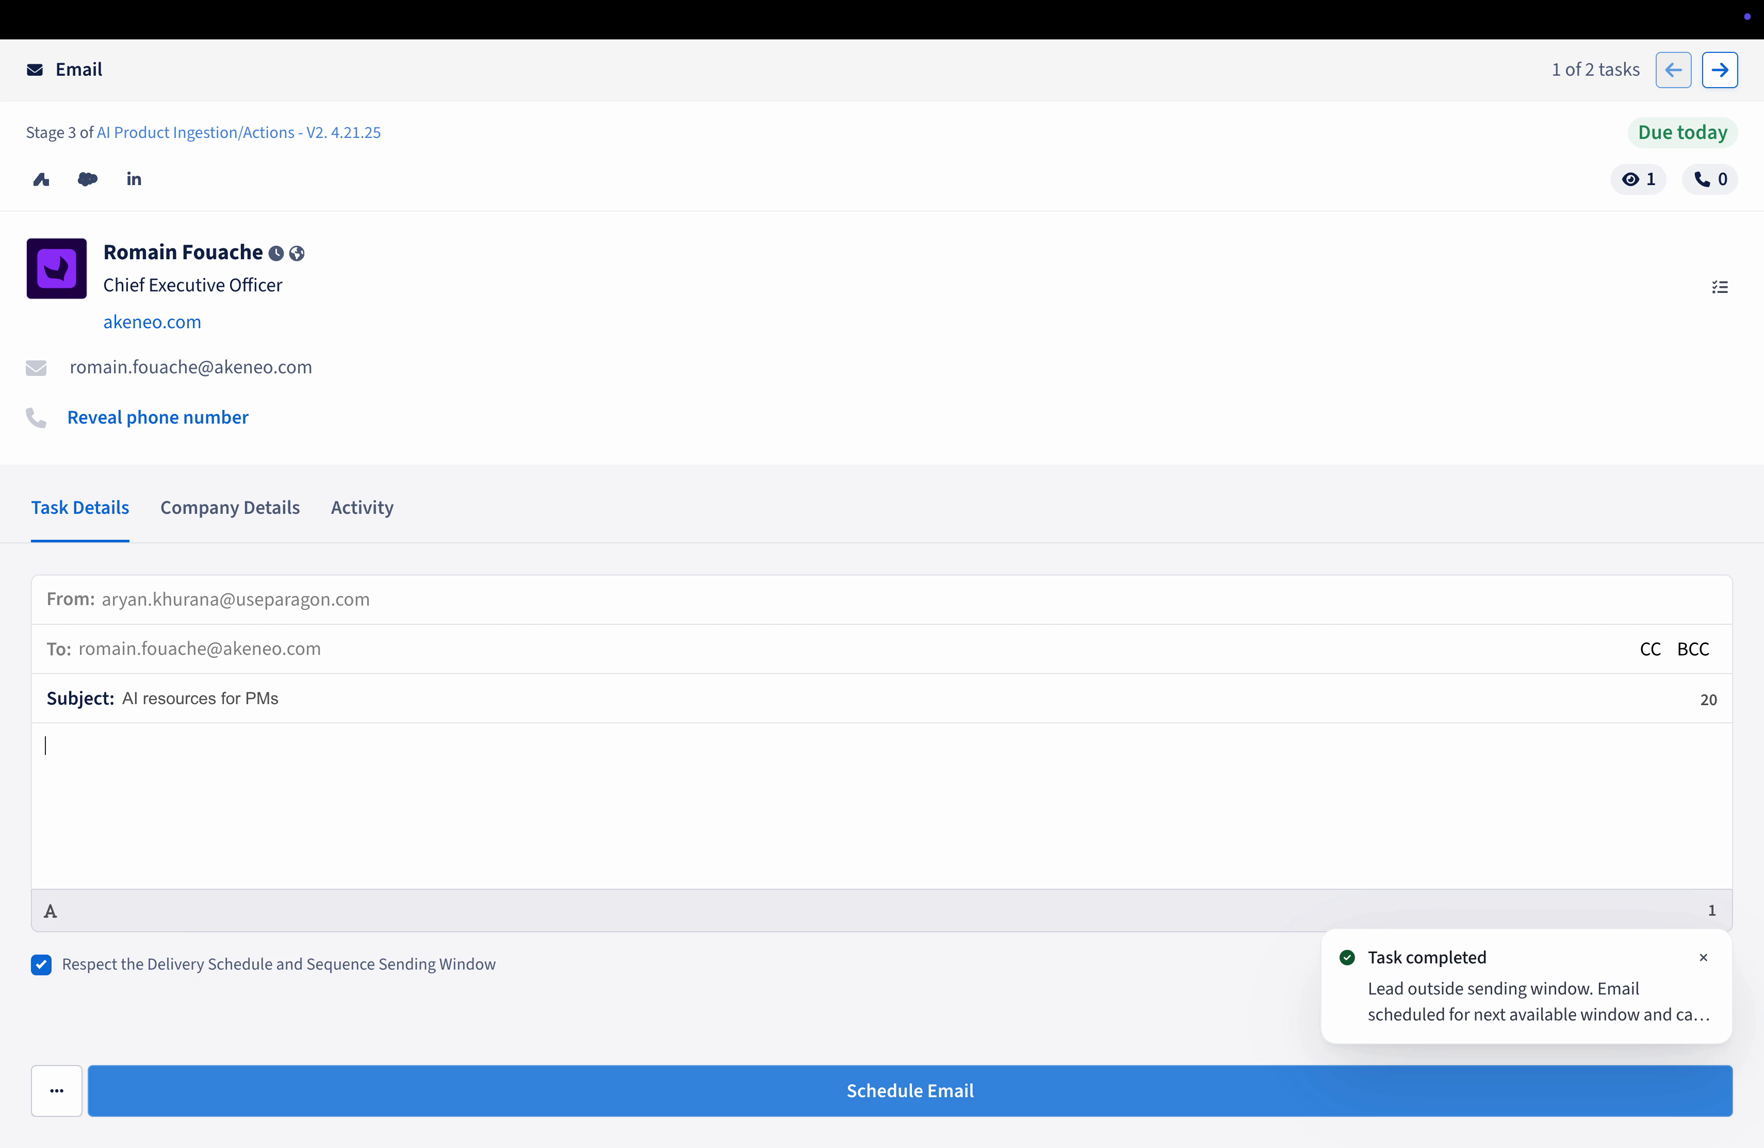
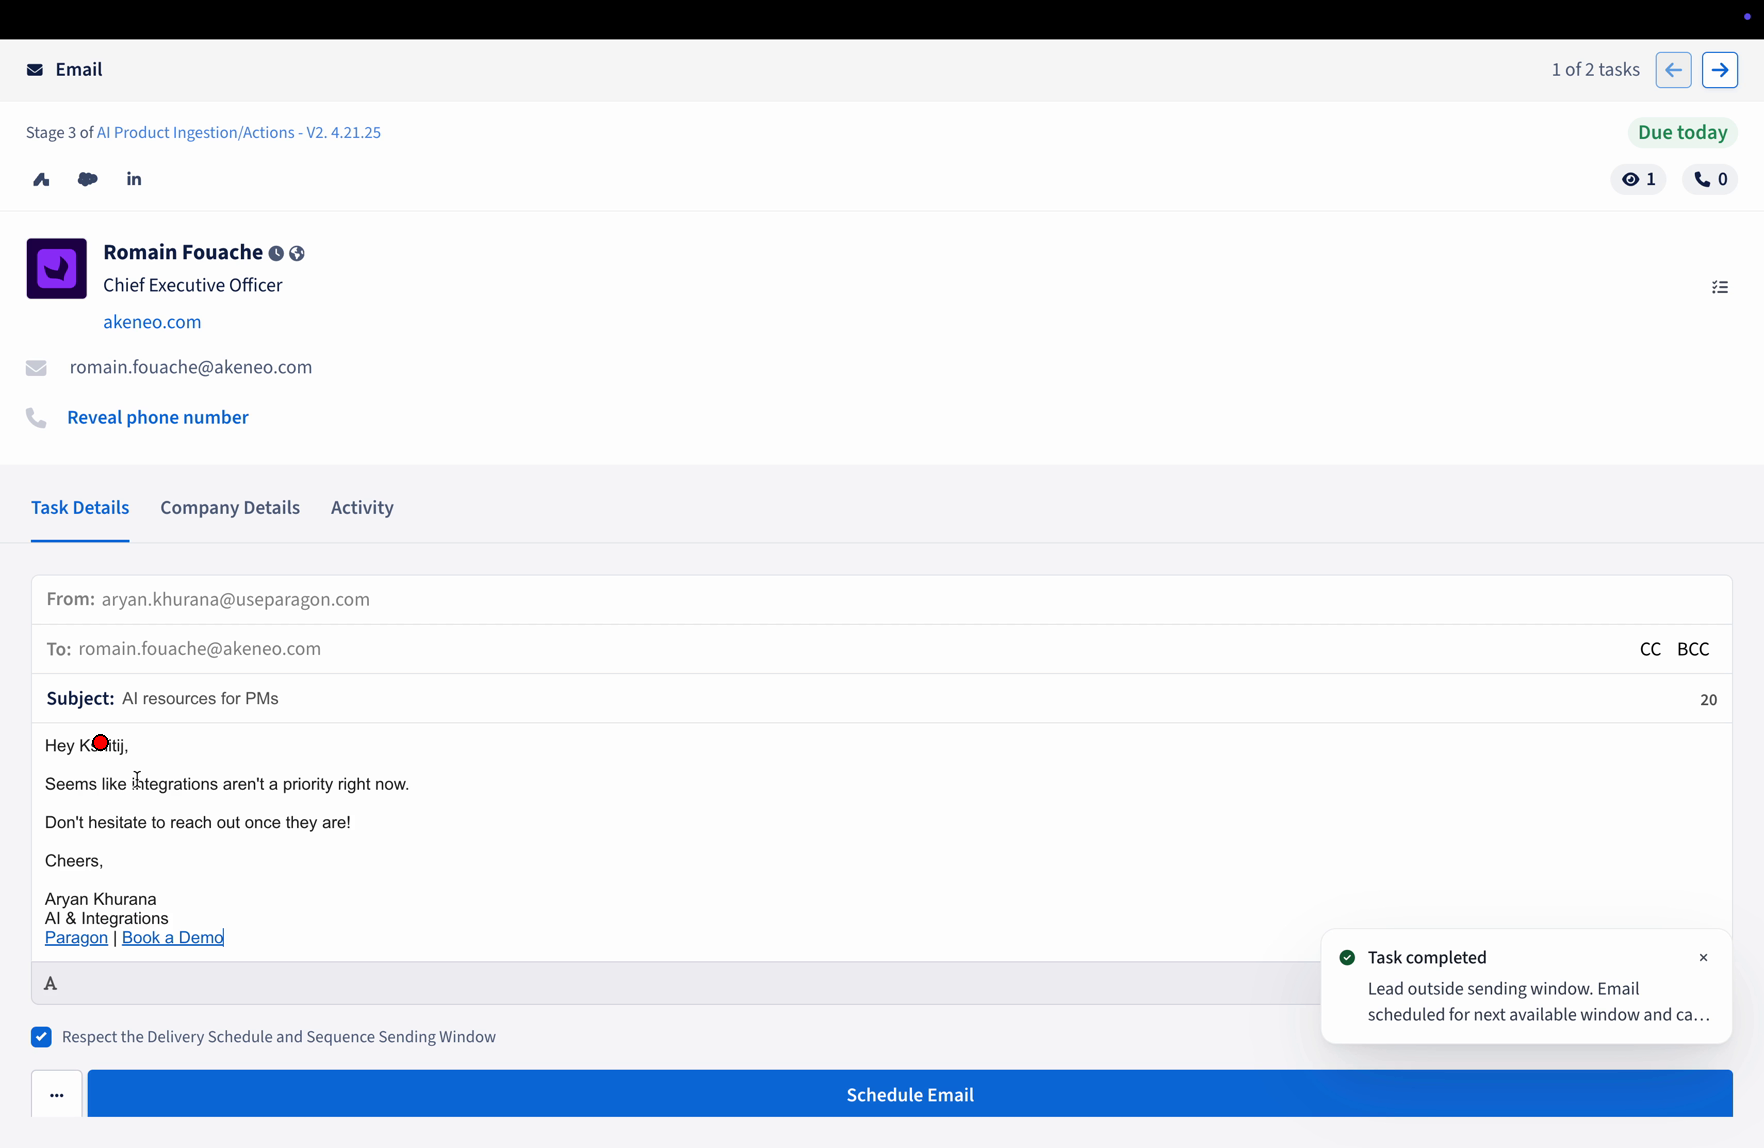
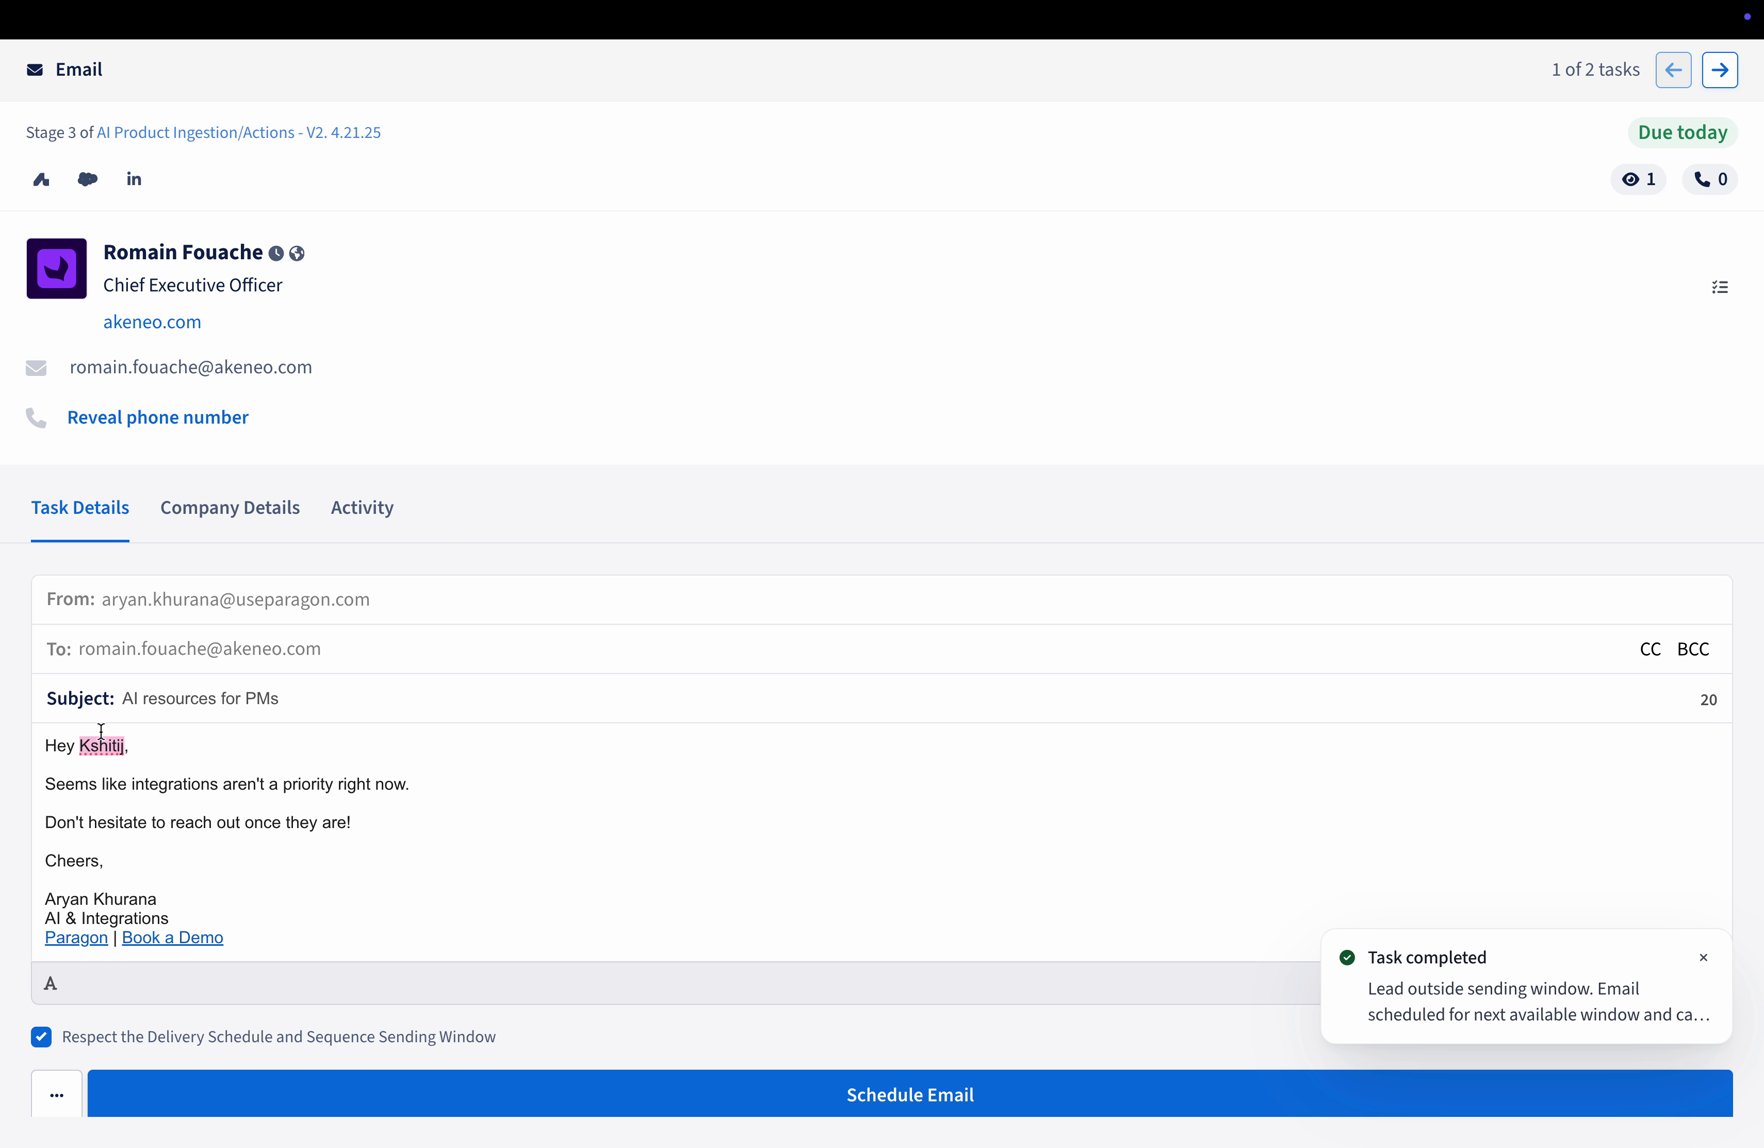
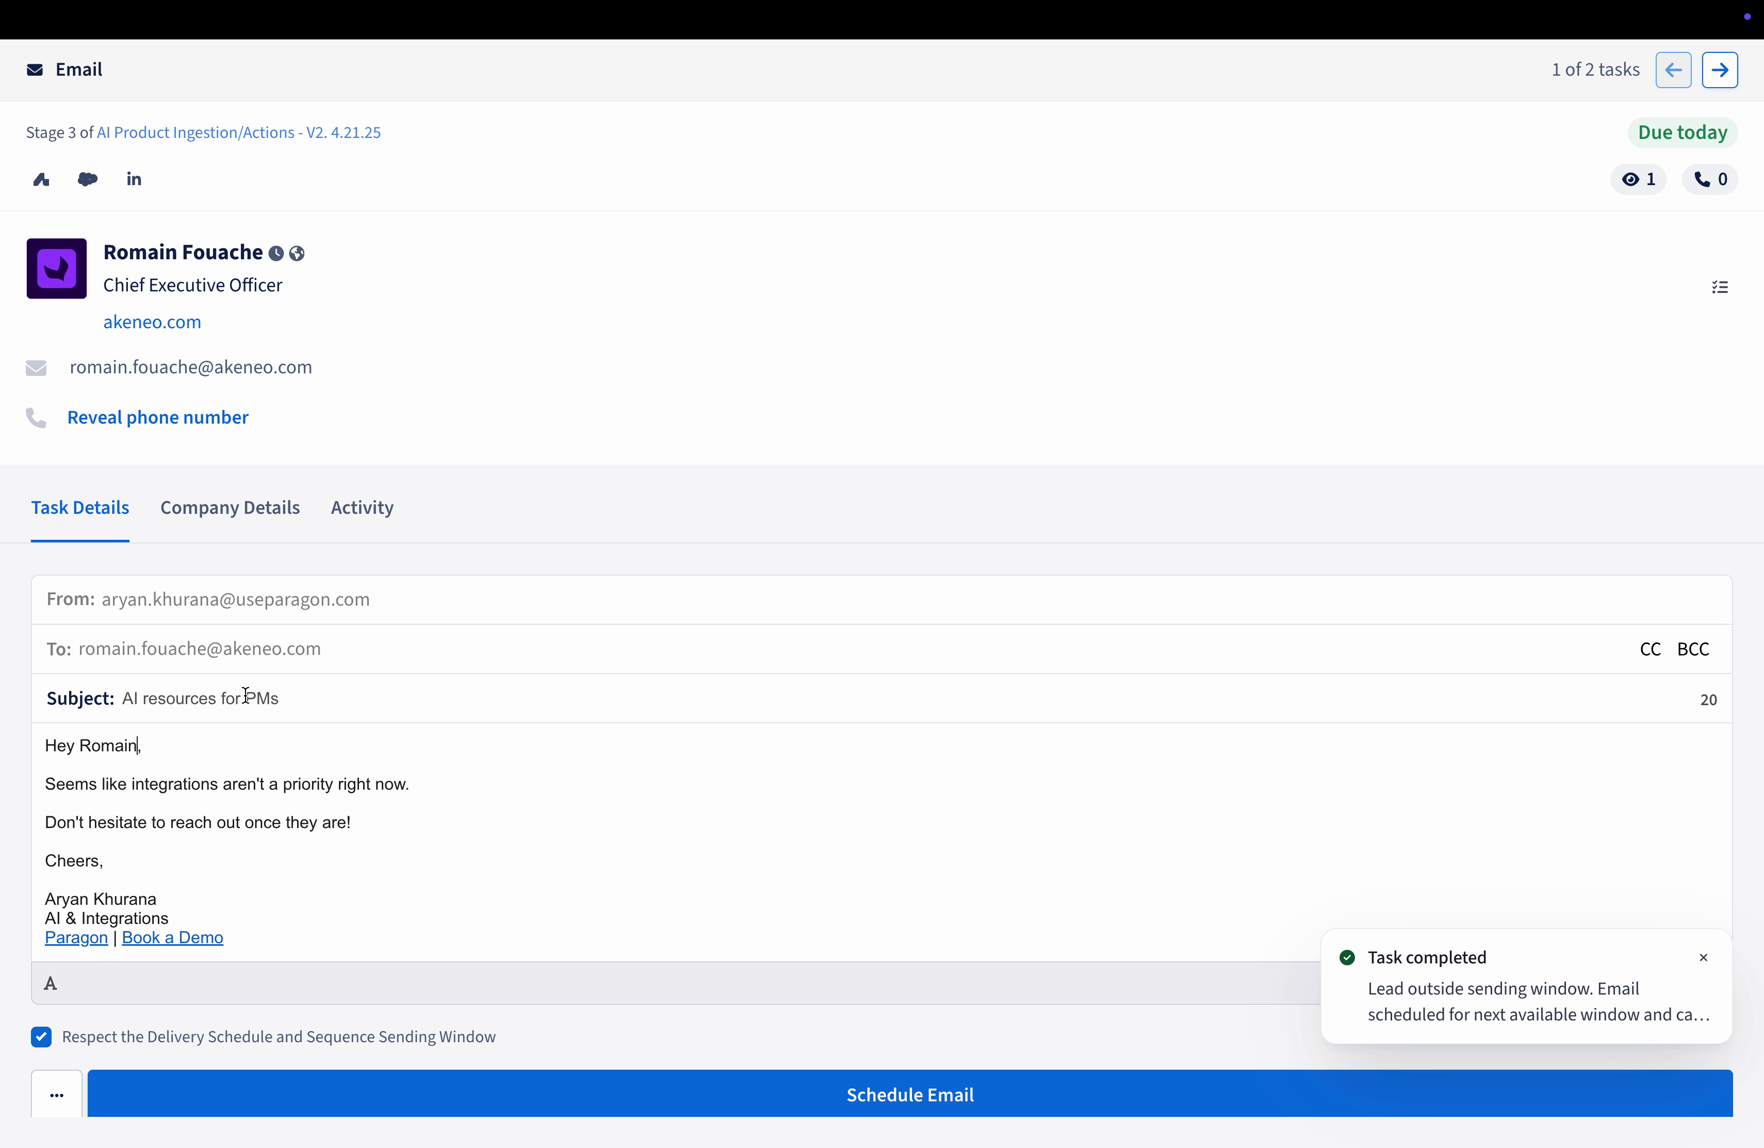
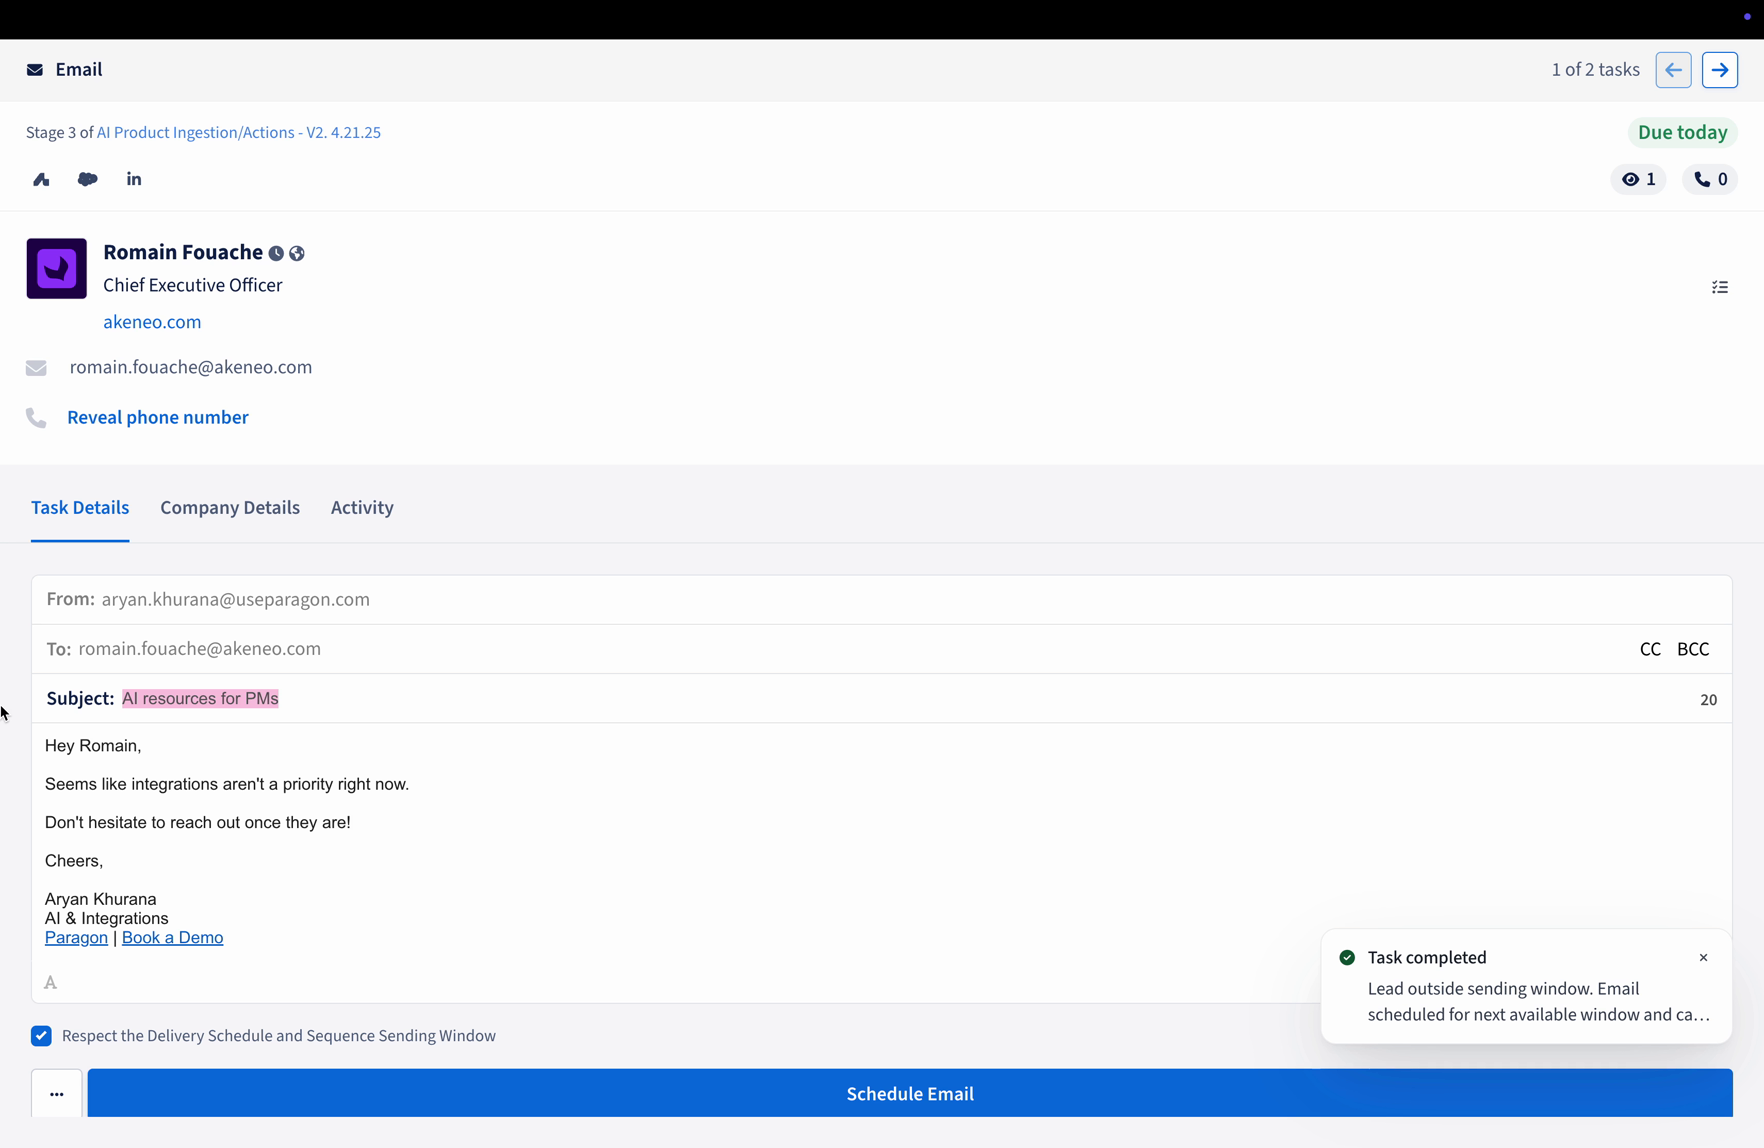
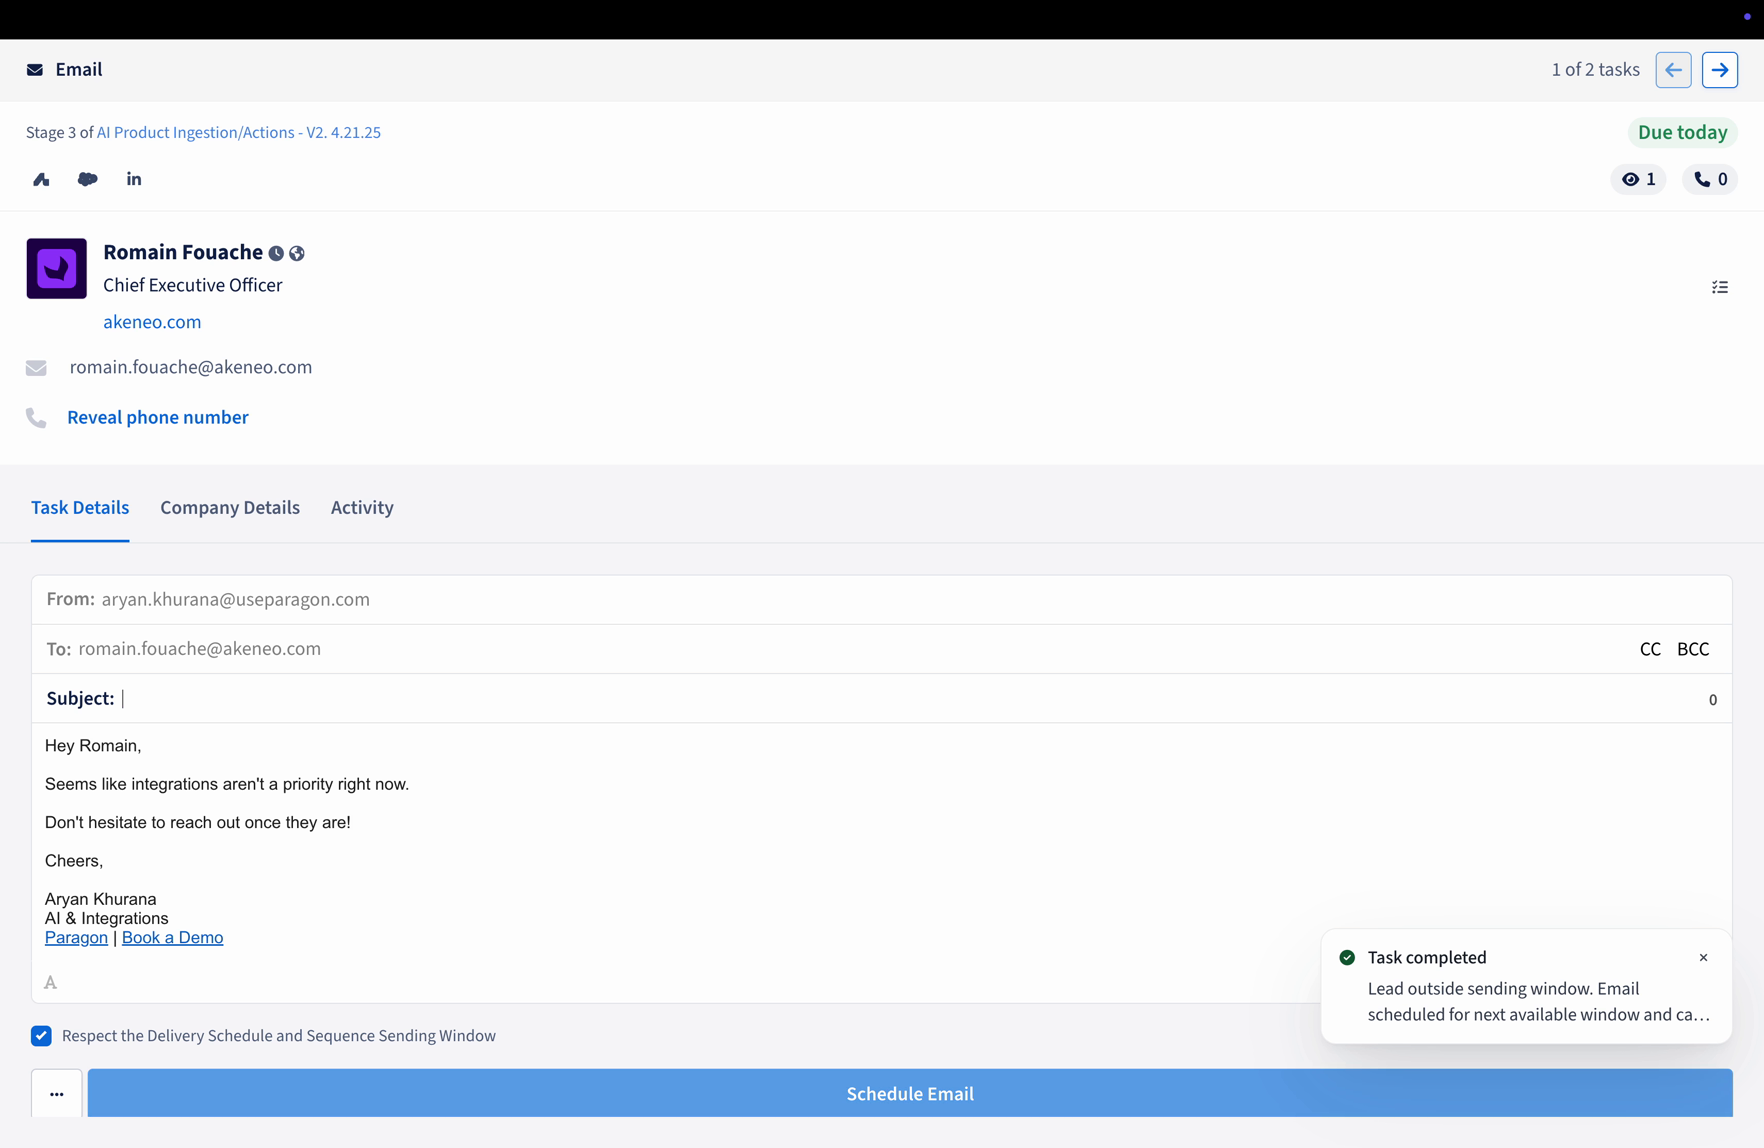

In [42]:
from synth.recordings.image_utils import pil_to_bytes
from synth.recordings.gemini_process import build_base_prompt, get_video_instruction, get_thinking_texts
from google.genai import types
frame_images = [k[0] for k in frames]
base_prompt = build_base_prompt(last_frame=frame_images[-1], rest_frames=frame_images[:-1], actions=action_set)
base_prompt



In [43]:

from smart_open import open
import importlib
import synth.recordings.gemini_process
importlib.reload(synth.recordings.gemini_process)
from synth.recordings.gemini_process import get_should_filter
filter_rsp = get_should_filter( base_prompt)
assert filter_rsp is not None
filter_response, filter_cost = filter_rsp
print(filter_cost)
filter_response


{'prompt_tokens': 10373, 'completion_tokens': 208, 'total_tokens': 10581, 'model': 'o3', 'prompt_tokens_cached': 0, 'prompt_cache_hit_rate': 0.0, 'cost_usd': 0.02241}


FilterResponseSchema(analysis_summary='User is actively composing and editing outreach emails in a CRM/email sequencing tool: scheduling one email, copying template, pasting into another, customizing recipient name and subject. These are purposeful content-creation actions, not passive consumption or aimless clicks.', remove=False)

In [45]:


from synth.recordings.gemini_process import build_base_prompt, get_video_instruction, get_thinking_texts
video_instruction = get_video_instruction(
    base_prompt=base_prompt,
)
if not video_instruction:
  print("No video instruction ")
else:
  instruction_response, price_details = video_instruction
  print(price_details)
  print("Video instruction:", instruction_response)

{'prompt_tokens': 10124, 'completion_tokens': 1001, 'total_tokens': 11125, 'model': 'o3', 'prompt_tokens_cached': 0, 'prompt_cache_hit_rate': 0.0, 'cost_usd': 0.028255999999999996}
Video instruction: analysis_summary='The user opens the first email task, clicks the blue “Schedule Email” button to send/schedule it, then moves to the next task. In the second email they: (1) select the entire body with Cmd+A, (2) delete it, (3) paste a template message from the clipboard, (4) double-click the placeholder first-name and type the correct recipient name "Romain", and (5) select the subject line and delete it so it’s blank.' instruction='Schedule the first email, then in the next email task delete the current body, paste the integrations-template message, change the greeting to “Hey Romain,” and clear the subject line.'


In [46]:
import importlib
import synth.recordings.gemini_process
importlib.reload(synth.recordings.gemini_process)
from synth.recordings.gemini_process import  get_thinking_texts

thinking_texts, thinking_costs = get_thinking_texts(
            base_prompt,
            instruction_response.instruction,
            action_set[:3],
        )
print(thinking_costs)
thinking_texts
# samples_df.to_json("gs://induction-labs/passive_data/2025-08-09/first_test_batch/samples.jsonl", lines=True, orient="records")

[{'prompt_tokens': 10671, 'completion_tokens': 242, 'total_tokens': 10913, 'model': 'o3', 'prompt_tokens_cached': 0, 'prompt_cache_hit_rate': 0.0, 'cost_usd': 0.023278}, {'prompt_tokens': 10771, 'completion_tokens': 2554, 'total_tokens': 13325, 'model': 'o3', 'prompt_tokens_cached': 0, 'prompt_cache_hit_rate': 0.0, 'cost_usd': 0.041974}, {'prompt_tokens': 10876, 'completion_tokens': 486, 'total_tokens': 11362, 'model': 'o3', 'prompt_tokens_cached': 0, 'prompt_cache_hit_rate': 0.0, 'cost_usd': 0.02564}]


[ThinkingTextResponse(user_monologue='The first task’s email to John Byrne is already filled in—the subject is “integrations,” the body looks correct, and the checkbox for respecting the delivery schedule is ticked. My job for this step is simply to schedule it. The long blue “Schedule Email” bar spans the bottom center of the window, so I’ll click it to mark this email as completed and move to the next task.', is_loading=False),
 ThinkingTextResponse(user_monologue='The email to John is still on screen—the subject field shows “integrations,” the body is complete, and the long blue bar labeled “Schedule Email” still stretches across the bottom center. That bar should disappear once the task is queued, so it looks like my earlier click didn’t register. I’ll press Command and click the Schedule Email bar again to force the system to mark this message as scheduled and advance me to the next task.', is_loading=False),
 ThinkingTextResponse(user_monologue='The second email task is open; the